In [354]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import combinations, permutations, product
import scipy
import sys
import copy
import pprint
import time

#powered by: 3.6.4 |Anaconda, Inc.| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
#print("powered by: %s"%sys.version)

In [370]:
df = pd.read_csv('boston_data.csv')
print("objects: %d\nfeatures: %d\n"%(df.shape[0], df.shape[1]-1))

objects: 404
features: 13



In [371]:
print(df.describe())

             crim          zn       indus        chas         nox         rm  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.00000   
mean     3.730912   10.509901   11.189901    0.069307    0.556710    6.30145   
std      8.943922   22.053733    6.814909    0.254290    0.117321    0.67583   
min      0.006320    0.000000    0.460000    0.000000    0.392000    3.56100   
25%      0.082382    0.000000    5.190000    0.000000    0.453000    5.90275   
50%      0.253715    0.000000    9.795000    0.000000    0.538000    6.23050   
75%      4.053158   12.500000   18.100000    0.000000    0.631000    6.62925   
max     88.976200   95.000000   27.740000    1.000000    0.871000    8.78000   

              age         dis         rad         tax     ptratio       black  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean    68.601733    3.799666    9.836634  411.688119   18.444554  355.068243   
std     28.066143    2.109916    8.8

In [372]:
#y -> target
y = df.medv
features = df.drop(['medv'], axis=1)

def calc_MAE(features, y, regression_type, alpha=""):
    X_train, X_test, Y_train, Y_test = train_test_split(features, y, test_size = 0.3, random_state = 1)
    
    regression_types = {
    "linear": LinearRegression(),
    "lasso": Lasso(alpha=alpha),
    "ridge": Ridge(alpha=alpha)
    }
    
    reg = regression_types[regression_type]
    reg.fit(X_train, Y_train)
    pred = reg.predict(X_test)
    return MAE(Y_test, pred), reg


MAE_, reg = calc_MAE(features, y, "linear", alpha="")
print(MAE_)

3.108930421899782


In [373]:
pd.DataFrame({"feature": features.columns, "importance": reg.coef_})

,feature,importance
0,crim,-0.106127
1,zn,0.038094
2,indus,0.019623
3,chas,1.682880
4,nox,-9.866563
5,rm,4.457378
6,age,-0.015691
7,dis,-1.191660
8,rad,0.240355
9,tax,-0.012482


C:\Users\Eugene\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


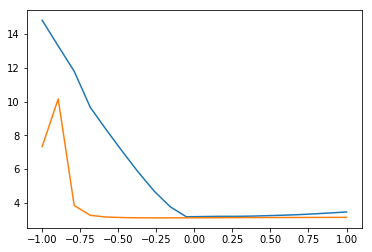

3.169657673549222 3.1016415616532855


In [374]:
"""
Подберем оптимальный гиперпараметр alpha
"""

params = np.linspace(-1, 1 ,20)

lasso_results = []
ridge_results = []

for alpha in params:
    lasso_results.append(calc_MAE(features, y, "lasso", alpha)[0])
    ridge_results.append(calc_MAE(features, y, "ridge", alpha)[0])
    
plt.plot(params, lasso_results, params, ridge_results)
plt.show()


"""
Качество относительно выбранной функции потерь MAE существенно улучшить не удалось
"""
print(min(lasso_results), min(ridge_results))

In [375]:
"""
Попробуем оценить влияние масштабирования признаков на результаты модели
"""

#выбираем способ масштабирования
scalers = {"min_max_scaler": MinMaxScaler(),
           "standard_scaler": StandardScaler()}


"""
Как мы можем видеть, масштабирование не оказывает никакого влияния на качество модели
"""

for scaler in scalers.values():
    scaled_features = copy.deepcopy(features)
    scaled_features[[column for column in scaled_features.columns]] = scaler.fit_transform(scaled_features[[column for column in scaled_features.columns]])

    print(scaled_features.describe(), "\n")

    MAE_, reg = calc_MAE(scaled_features, y, "linear", alpha="")
    print(MAE_, "\n")


             crim          zn       indus        chas         nox          rm  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     0.041864    0.110631    0.393325    0.069307    0.343863    0.525091   
std      0.100528    0.232145    0.249813    0.254290    0.244928    0.129494   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000855    0.000000    0.173387    0.000000    0.127349    0.448697   
50%      0.002781    0.000000    0.342192    0.000000    0.304802    0.511496   
75%      0.045485    0.131579    0.646628    0.000000    0.498956    0.587900   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              age         dis         rad         tax     ptratio       black  \
count  404.000000  404.000000  404.000000  404.000000  404.000000  404.000000   
mean     0.676640    0.240072    0.384201    0.428794    0.621761    0.894519   
std      0.289044    0.1925

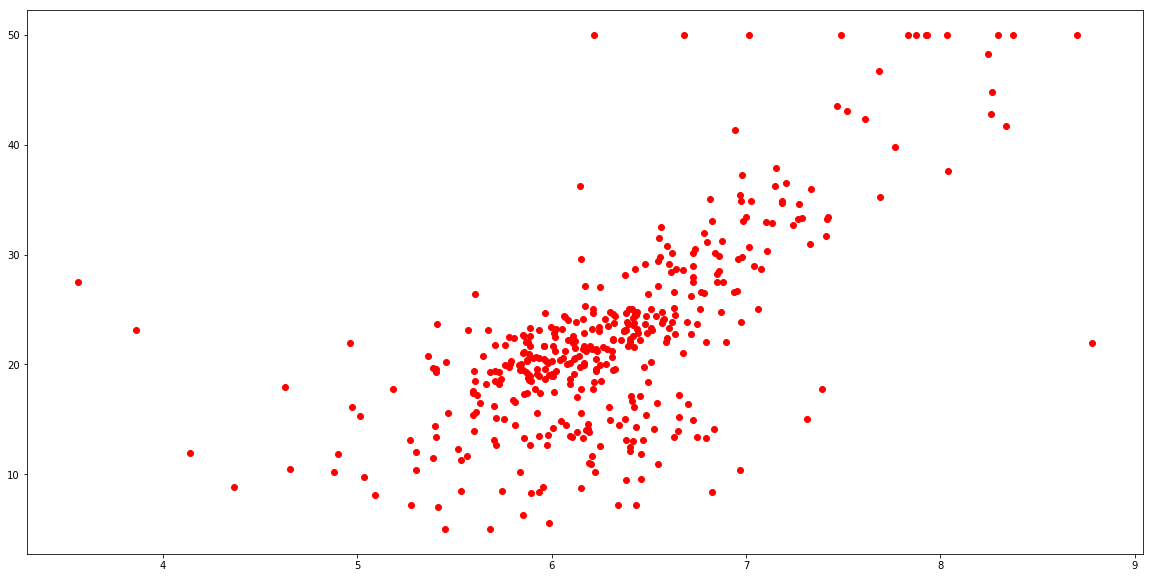

In [376]:
plt.figure(figsize=(20, 10))
plt.plot(features['rm'], y, 'o', c='red')
plt.show()

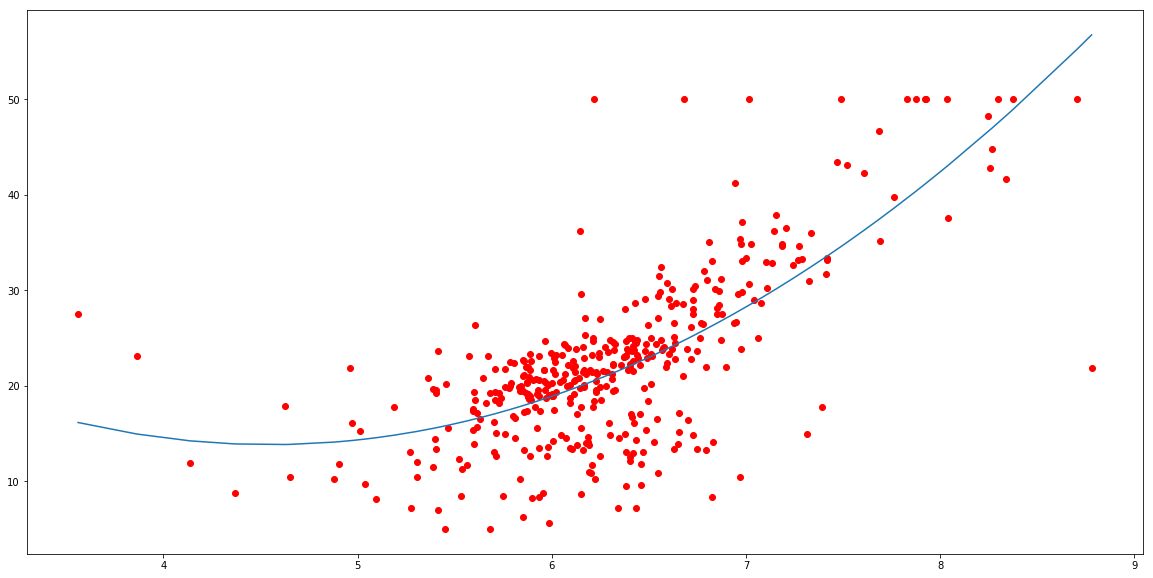

In [377]:
coefs = scipy.polyfit(features.rm, y, deg = 2)
poly = scipy.poly1d(coefs)
plt.figure(figsize=(20, 10))
plt.scatter(features.rm, y, c='red')
plt.plot(sorted(features.rm), poly(sorted(features.rm)))
plt.show()

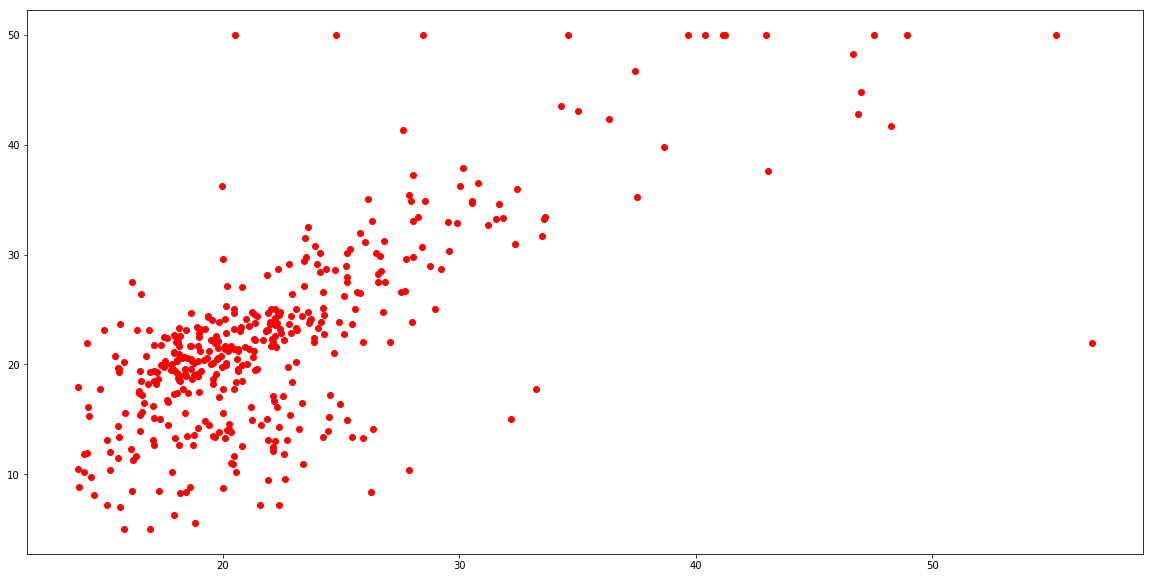

2.617879060539027


In [378]:
features['rm'] = poly(np.array(features.rm))
plt.figure(figsize=(20, 10))
plt.plot(features['rm'], y, 'o', c='red')
plt.show()

"""
Качество улучшилось
"""

MAE_, reg = calc_MAE(features, y, "linear", alpha="")
print(MAE_)

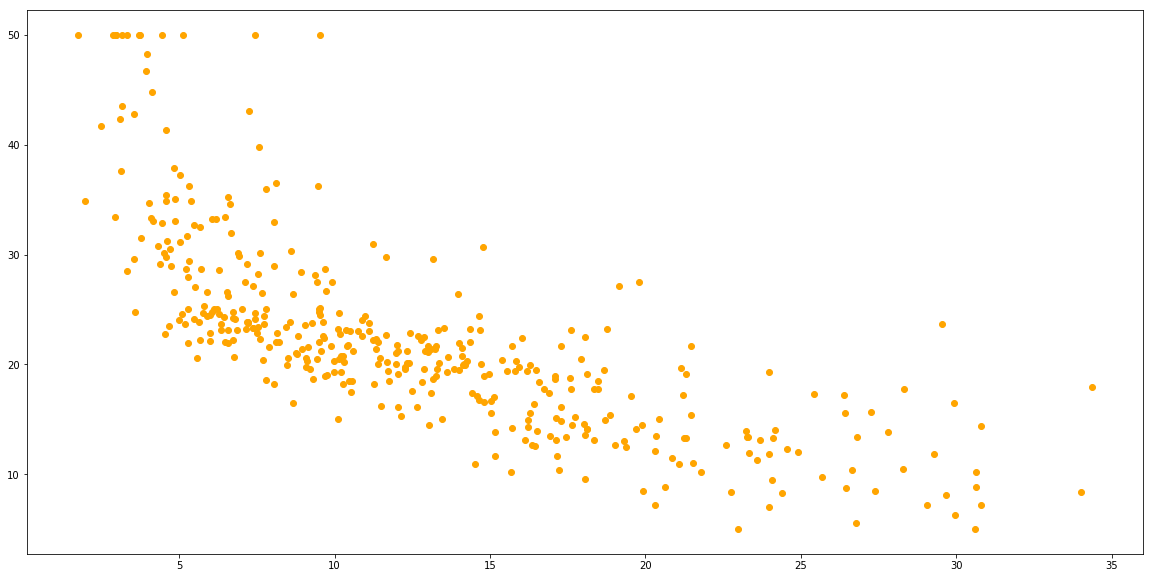

In [379]:
plt.figure(figsize=(20, 10))
plt.plot(features['lstat'], y, 'o', c='orange')
plt.show()

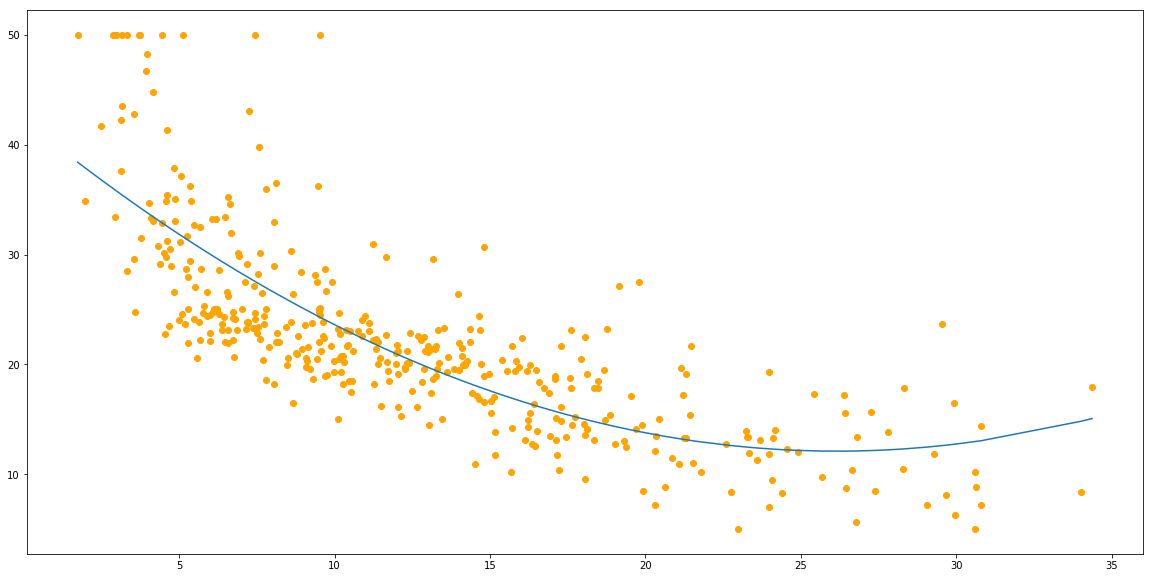

In [380]:
coefs = scipy.polyfit(features.lstat, y, deg = 2)
poly = scipy.poly1d(coefs)
plt.figure(figsize=(20, 10))
plt.scatter(features.lstat, y, c='orange')
plt.plot(sorted(features.lstat), poly(sorted(features.lstat)))
plt.show()

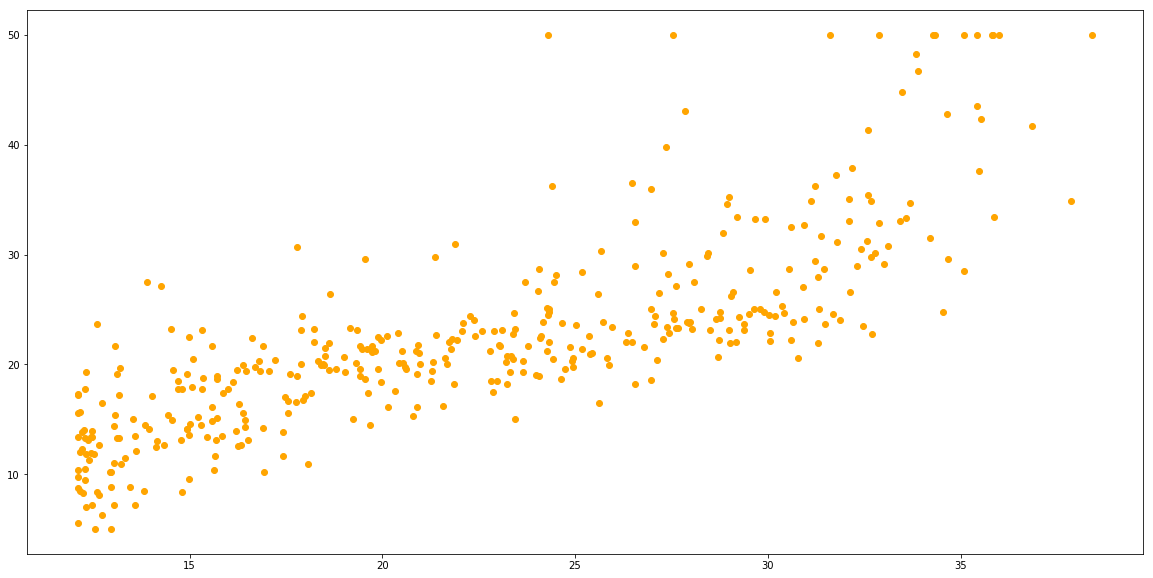

2.4894106489860865


In [381]:
features['lstat'] = poly(np.array(features.lstat))
plt.figure(figsize=(20, 10))
plt.plot(features['lstat'], y, 'o', c='orange')
plt.show()

"""
Качество улучшилось
"""

MAE_, reg = calc_MAE(features, y, "linear", alpha="")
print(MAE_)

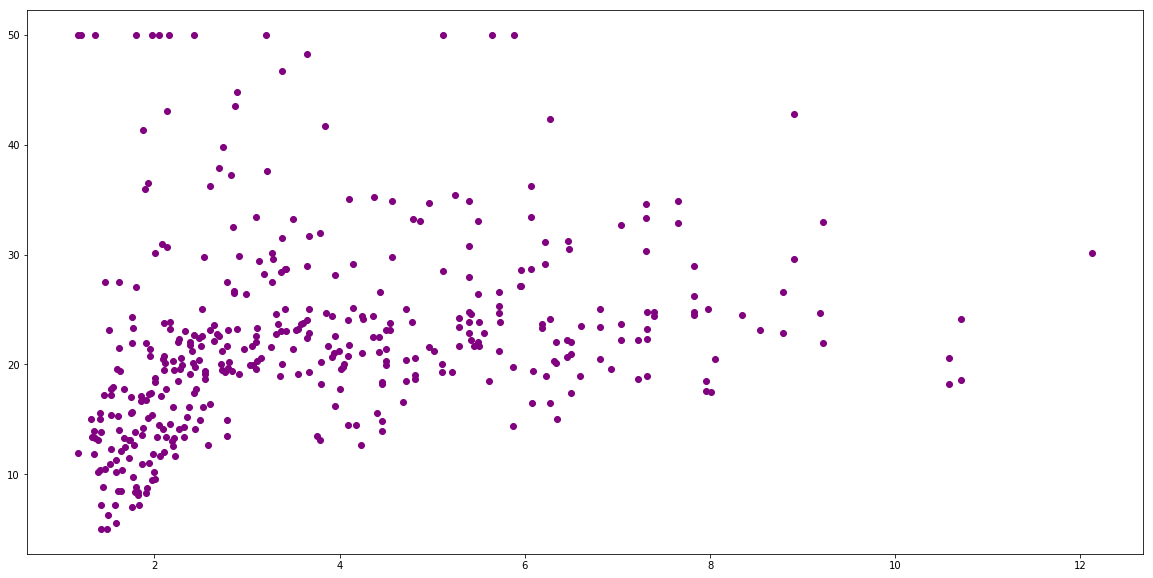

In [303]:
plt.figure(figsize=(20, 10))
plt.plot(features['dis'], y, 'o', c='purple')
plt.show()

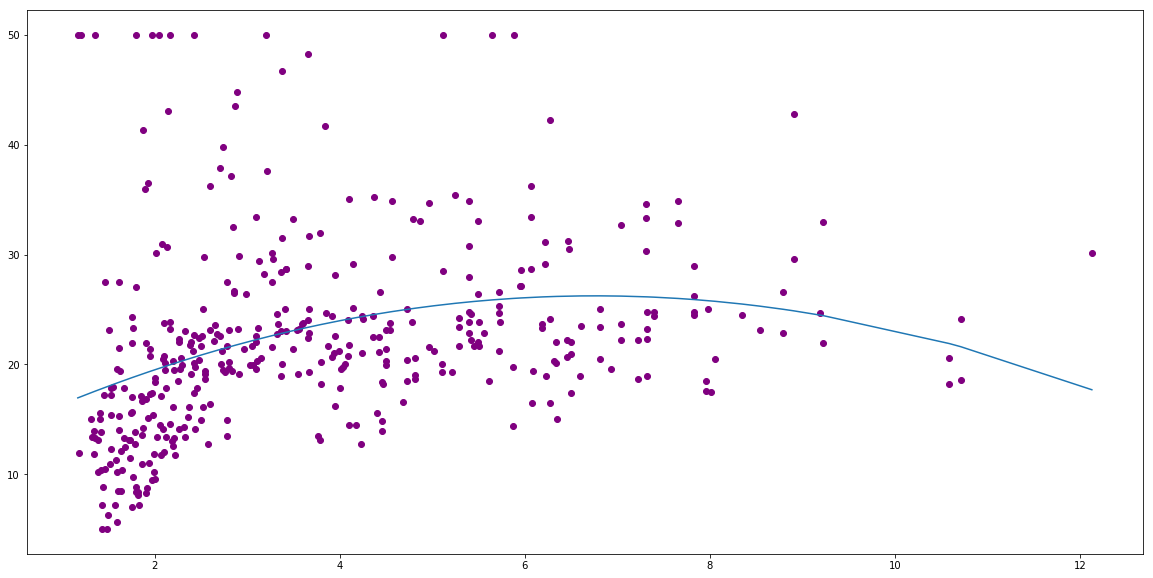

In [304]:
coefs = scipy.polyfit(features.dis, y, deg = 2)
poly = scipy.poly1d(coefs)
plt.figure(figsize=(20, 10))
plt.scatter(features.dis, y, c='purple')
plt.plot(sorted(features.dis), poly(sorted(features.dis)))
plt.show()

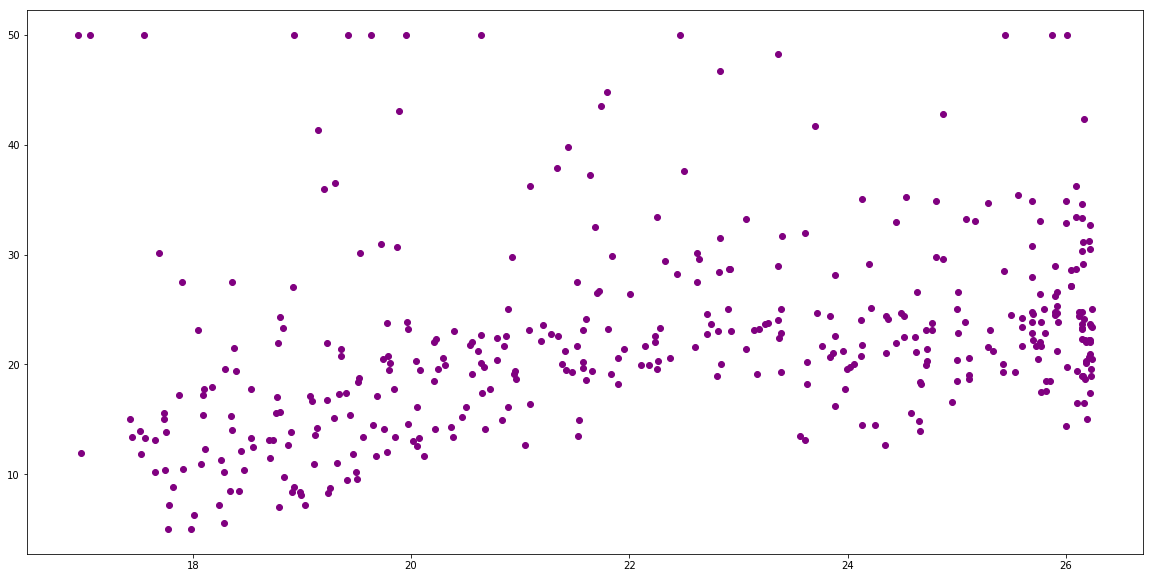

2.6903447007212065


In [305]:
features['dis'] = poly(np.array(features.dis))
plt.figure(figsize=(20, 10))
plt.plot(features['dis'], y, 'o', c='purple')
plt.show()

"""
Качество несколько ухудшилось
"""

MAE_, reg = calc_MAE(features, y, "linear", alpha="")
print(MAE_)

In [129]:
#Резюмируем:
#rm -> poly(rm)
#lstat -> poly(lstat)
#dis -> dis


crim_plus_indus
2.4894106489860643


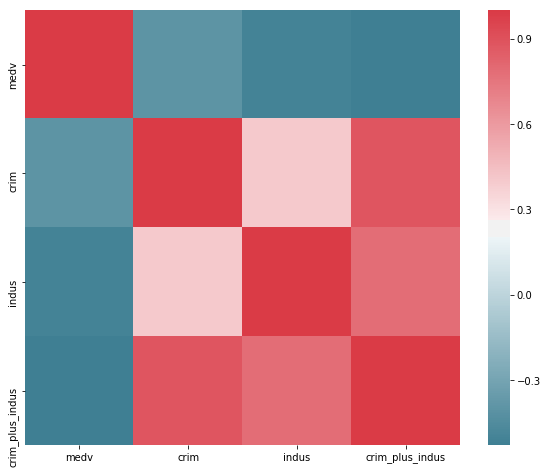

In [389]:
#ищем первую комбинацию регрессоров, которая усилит модель

df = pd.read_csv('boston_data.csv')
y = df.medv
features = df.drop(['medv'], axis=1)

coefs = scipy.polyfit(features.rm, y, deg = 2)
poly = scipy.poly1d(coefs)
features['rm'] = poly(np.array(features.rm))

coefs = scipy.polyfit(features.lstat, y, deg = 2)
poly = scipy.poly1d(coefs)
features['lstat'] = poly(np.array(features.lstat))

min_MAE = 100
best_linear_comb = ""

for combination in combinations(features.columns, 2):
   
    #сложение признаков
    #для сложения не важен порядок слагаемых, берем комбинации
    features["_plus_".join(combination)] = features[combination[0]]+features[combination[1]]
    
    MAE_, reg = calc_MAE(features, y, "linear", alpha="")
    if MAE_ < min_MAE:
        min_MAE = MAE_ 
        best_linear_comb = "_plus_".join(combination)
    
    features = features.drop(["_plus_".join(combination)], axis=1)
    
    
print(best_linear_comb)
print(min_MAE)

df[best_linear_comb] = df[best_linear_comb.split('_')[0]]+df[best_linear_comb.split('_')[2]]


"""
Комбинация crim + indus плохо коррелирует с целевой функцией, модель она практически не усиливает
"""

df = df[['medv', 'crim', 'indus', 'crim_plus_indus']]
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()



chas_minus_tax
2.489410648986062


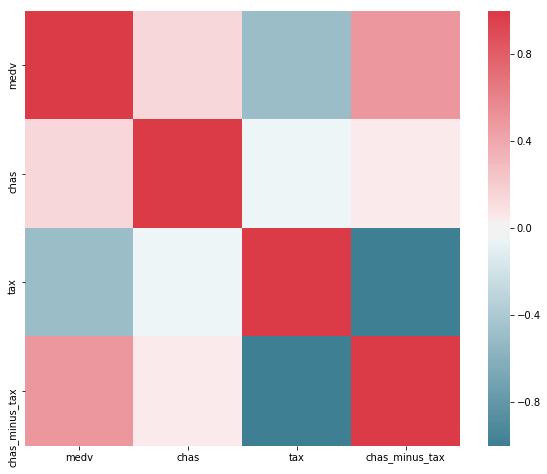

In [391]:
#ищем вторую комбинацию регрессоров, которая усилит модель

df = pd.read_csv('boston_data.csv')
y = df.medv
features = df.drop(['medv'], axis=1)

coefs = scipy.polyfit(features.rm, y, deg = 2)
poly = scipy.poly1d(coefs)
features['rm'] = poly(np.array(features.rm))

coefs = scipy.polyfit(features.lstat, y, deg = 2)
poly = scipy.poly1d(coefs)
features['lstat'] = poly(np.array(features.lstat))


min_MAE = 100
best_linear_comb = ""

for permutation in permutations(features.columns, 2):
 
    #вычитание
    #для вычитания важен порядок, берем перестановки
    features["_minus_".join(permutation)] = features[permutation[0]]-features[permutation[1]]
    
    MAE_, reg = calc_MAE(features, y, "linear", alpha="")
    if MAE_ < min_MAE:
        min_MAE = MAE_ 
        best_linear_comb = "_minus_".join(permutation)
    
    features = features.drop(["_minus_".join(permutation)], axis=1)
    
    
print(best_linear_comb)
print(min_MAE)

df[best_linear_comb] = df[best_linear_comb.split('_')[0]]-df[best_linear_comb.split('_')[2]]


"""
Комбинация chas - tax плохо коррелирует с целевой функцией, модель она практически не усиливает
"""

df = df[['medv', 'chas', 'tax', 'chas_minus_tax']]
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()


lstat_mul_black
2.5331939545763595


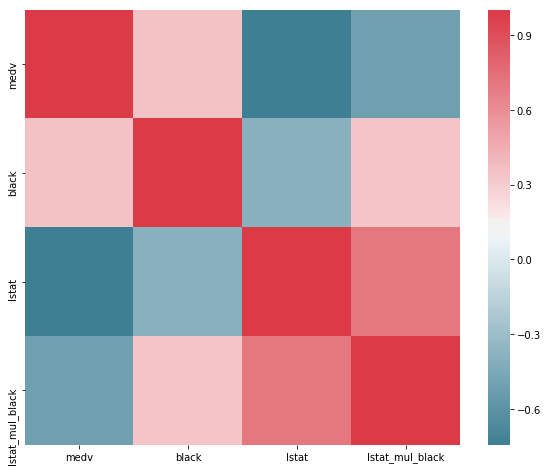

In [392]:
#ищем третью комбинацию регрессоров, которая усилит модель

df = pd.read_csv('boston_data.csv')
y = df.medv
features = df.drop(['medv'], axis=1)

coefs = scipy.polyfit(features.rm, y, deg = 2)
poly = scipy.poly1d(coefs)
features['rm'] = poly(np.array(features.rm))

coefs = scipy.polyfit(features.lstat, y, deg = 2)
poly = scipy.poly1d(coefs)
features['lstat'] = poly(np.array(features.lstat))

min_MAE = 100
best_linear_comb = ""


for prod in product(features.columns, repeat=2):
 
    #умножение
    #для умножения важен как порядок, так и входящие элементы, берем сочетания
    
    features["_mul_".join(permutation)] = features[permutation[0]]*features[permutation[1]]
  
    MAE_, reg = calc_MAE(features, y, "linear", alpha="")
    if MAE_ < min_MAE:
        min_MAE = MAE_ 
        best_linear_comb = "_mul_".join(permutation)
    
    features = features.drop(["_mul_".join(permutation)], axis=1)

print(best_linear_comb)
print(min_MAE)

df[best_linear_comb] = df[best_linear_comb.split('_')[0]]*df[best_linear_comb.split('_')[2]]


"""
Комбинация lstat_mul_black слабо коррелирует с целевой функцией, модель становится слабее
"""

df = df[['medv', 'black', 'lstat', 'lstat_mul_black']]
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype = np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)
plt.show()


In [414]:
"""
Собираем все вместе:

1) Используем обычную линейную модель, так как ни Lasso ни Ridge не дают ощутимого прироста качества
2) Отказываемся от масштабирования признаков, так как это тоже не играет большой роли
3) Для признаков lm и lstat применяем приобразвание, приближающее зависимость к линейной, так как качество модели в этом случае улучшается
4) Никаких линейных комбинаций в модель не добавляем, так как не удалось найти такую комбинацию, которой модель можно усилисть 
"""


df = pd.read_csv('boston_data.csv')
y = df.medv
features = df.drop(['medv'], axis=1)

coefs = scipy.polyfit(features.rm, y, deg = 2)
poly = scipy.poly1d(coefs)
features['rm'] = poly(np.array(features.rm))

coefs = scipy.polyfit(features.lstat, y, deg = 2)
poly = scipy.poly1d(coefs)
features['lstat'] = poly(np.array(features.lstat))



X_train, X_test, Y_train, Y_test = train_test_split(features, y, test_size = 0.3, random_state = 1)
reg = LinearRegression()
reg.fit(X_train, Y_train)
pred = reg.predict(X_test)
print(MAE(Y_test, pred), "\n")


pd.DataFrame({"feature": features.columns, "importance": reg.coef_})

2.5131160954295577 



,feature,importance
0,crim,-0.170255
1,zn,0.727004
2,indus,-0.007402
3,chas,1.525665
4,nox,-12.367287
5,rm,0.446905
6,age,0.004096
7,dis,-0.847242
8,rad,0.199223
9,tax,-0.009340


In [406]:
"""
Напоследок, попробуем убрать из модели все незначимые регрессоры
"""

df = pd.read_csv('boston_data.csv')
y = df.medv
features = df.drop(['medv', 'age', 'black', 'zn', 'indus', 'tax'], axis=1)

coefs = scipy.polyfit(features.rm, y, deg = 2)
poly = scipy.poly1d(coefs)
features['rm'] = poly(np.array(features.rm))

coefs = scipy.polyfit(features.lstat, y, deg = 2)
poly = scipy.poly1d(coefs)
features['lstat'] = poly(np.array(features.lstat))


X_train, X_test, Y_train, Y_test = train_test_split(features, y, test_size = 0.3, random_state = 1)
reg = LinearRegression()
reg.fit(X_train, Y_train)
pred = reg.predict(X_test)
print(MAE(Y_test, pred), "\n")


pd.DataFrame({"feature": features.columns, "importance": reg.coef_})

"""
Качество немного упало, однако количество регрессоров сократилось вдвое, что положительно скажется на вычислительной 
сложности задачи и (скорее всего) на обобщающей способности модели
"""

2.615654881579228 



'\nКачество немного упало, однако количество регрессоров сократилось вдвое, что положительно скажется на вычислительной \nсложности задачи и (скорее всего) на обобщающей способности модели\n'

In [413]:
df = pd.read_csv('boston_test_data.csv')
df = df.drop(['age', 'black', 'zn', 'indus', 'tax'], axis=1)
pred = reg.predict(df)

s = pd.DataFrame({'id': np.arange(len(pred)), 'price': pred})
s.to_csv('submission.csv', index=False)

2.4894106489860865 

